In [ ]:
from functools import partial
import os

# importing important libraries 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

%matplotlib inline

## Loading the dataset

In [ ]:
# load the dataset 
images_dir = '/kaggle/input/satellite-images-dataset/Water Bodies Dataset/Images'
masks_dir = '/kaggle/input/satellite-images-dataset/Water Bodies Dataset/Masks'

dirnames , _, filenames = next(os.walk(images_dir))

In [ ]:
len(filenames)

In [ ]:
@tf.function
def load_img_with_mask(image_path, images_dir: str = 'Images', masks_dir: str = 'Masks',images_extension: str = 'jpg', masks_extension: str = 'jpg') -> dict:
    # read the images files using tf.io
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)

    # convert images files into mask files
    mask_filename = tf.strings.regex_replace(image_path, images_dir, masks_dir)
    mask_filename = tf.strings.regex_replace(mask_filename, images_extension, masks_extension)
    
    # read the masks image files
    mask = tf.io.read_file(mask_filename)
    mask = tf.image.decode_image(mask, channels=1, expand_animations = False)
    return (image, mask)

## Visualizing the satelite image data

In [ ]:
# visualize the some images
n_images = 5
# create list of images and mask using above funtion
examples = [load_img_with_mask(os.path.join(images_dir, filenames[i])) for i in range(n_images)]

# plot the images using matplotlib pyplot
fig, axs = plt.subplots(n_images,2, figsize=(14,n_images*7), constrained_layout=True)
for ax, (img, msk) in zip(axs, examples):
    ax[0].imshow(img)
    ax[1].imshow(msk)

In [ ]:
# visualizing the image channels in one example
fig, axs = plt.subplots(2, 2, figsize=(14,14), constrained_layout=True)
example_image, example_mask = examples[2]
example_image = np.array(example_image)
example_mask = np.squeeze(example_mask)
axs[0][0].imshow(example_image)
axs[0][1].hist(example_image[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
axs[0][1].hist(example_image[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
axs[0][1].hist(example_image[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)

axs[1][0].imshow(example_mask)
histogram, bin_edges = np.histogram(example_mask, bins=256)
axs[1][1].plot(bin_edges[0:-1], histogram);

## Preprocessing the dataset

In [ ]:
@tf.function
def resize_images(images, masks, max_image_size=1500):
    shape = tf.shape(images)
    scale = (tf.reduce_max(shape) // max_image_size) + 1
    target_height, target_width = shape[-3] // scale, shape[-2] // scale
    images = tf.cast(images, tf.float32)
    masks = tf.cast(masks, tf.float32)
    if scale != 1:
        images = tf.image.resize(images, (target_height, target_width), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        masks = tf.image.resize(masks, (target_height, target_width), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return (images, masks)

@tf.function
def scale_values(images, masks, mask_split_threshold = 128):
    images = tf.math.divide(images, 255)
    masks = tf.where(masks > mask_split_threshold, 1, 0)
    return (images, masks)

@tf.function
def pad_images(images, masks, pad_mul=16, offset=0):
    shape = tf.shape(images)
    height, width = shape[-3], shape[-2]
    target_height = height + tf.math.floormod(tf.math.negative(height), pad_mul)
    target_width = width + tf.math.floormod(tf.math.negative(width), pad_mul)
    images = tf.image.pad_to_bounding_box(images, offset, offset, target_height, target_width)
    masks = tf.cast(tf.image.pad_to_bounding_box(masks, offset, offset, target_height, target_width), tf.uint8)
    return (images, masks)

In [ ]:
batch_size = 32
test_set_size = 300
validation_set_size = 250

dataset = tf.data.Dataset.list_files(images_dir + '/*.jpg', seed=42)

test_dataset = dataset.take(test_set_size)
dataset = dataset.skip(test_set_size)
test_dataset = test_dataset.map(load_img_with_mask)
test_dataset = test_dataset.map(scale_values)
test_dataset = test_dataset.shuffle(20)
test_dataset = test_dataset.map(lambda img, mask: resize_images(img, mask, max_image_size=2500))
test_dataset = test_dataset.map(pad_images)
test_dataset = test_dataset.batch(1).prefetch(5)


validation_dataset = dataset.take(validation_set_size)
train_dataset = dataset.skip(validation_set_size)
validation_dataset = validation_dataset.map(load_img_with_mask)
validation_dataset = validation_dataset.map(scale_values)
validation_dataset = validation_dataset.shuffle(20)
validation_dataset = validation_dataset.map(resize_images)
validation_dataset = validation_dataset.map(pad_images)
validation_dataset = validation_dataset.batch(1).prefetch(5)

train_dataset = train_dataset.map(load_img_with_mask)
train_dataset = train_dataset.map(scale_values)
train_dataset = train_dataset.shuffle(20)
train_dataset = train_dataset.map(resize_images)
train_dataset = train_dataset.map(pad_images)
train_dataset = train_dataset.batch(1).prefetch(5)

## U-net image segmentation model architecture

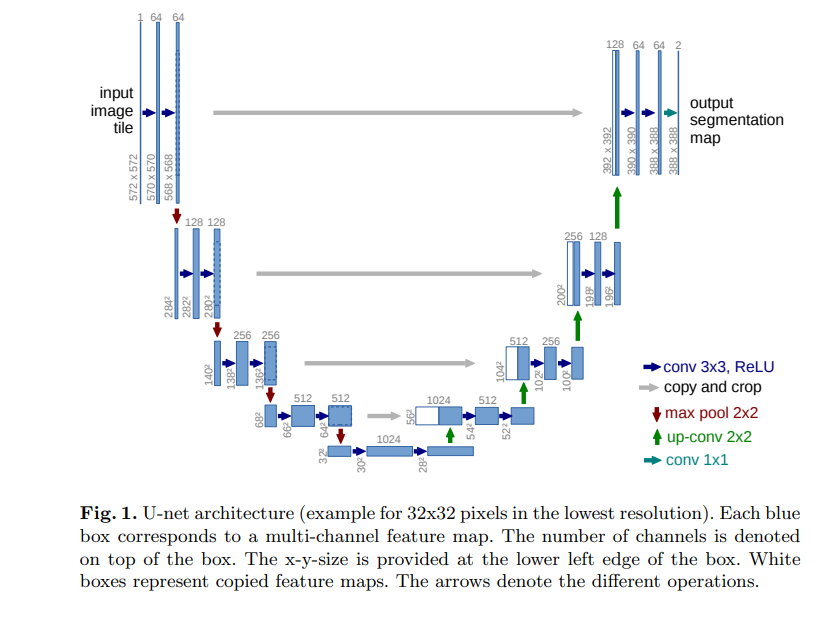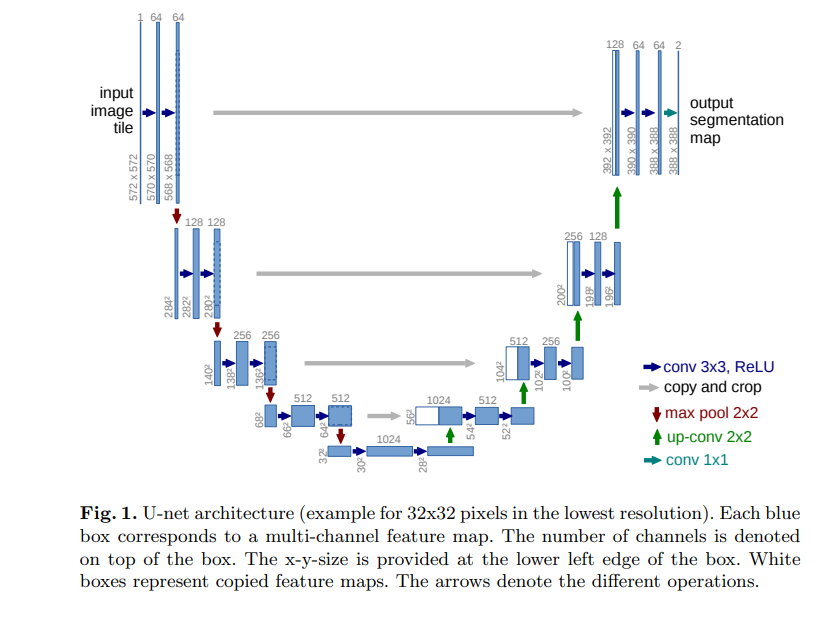

In [ ]:
def get_unet(hidden_activation='relu', initializer='he_normal', output_activation='sigmoid'):
    PartialConv = partial(keras.layers.Conv2D,
     activation=hidden_activation,
     kernel_initializer=initializer,      
     padding='same')
    
    # Encoder
    model_input = keras.layers.Input(shape=(None, None, 3))
    enc_cov_1 = PartialConv(32, 3)(model_input)
    enc_cov_1 = PartialConv(32, 3)(enc_cov_1)
    enc_pool_1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(enc_cov_1)
    
    enc_cov_2 = PartialConv(64, 3)(enc_pool_1)
    enc_cov_2 = PartialConv(64, 3)(enc_cov_2)
    enc_pool_2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(enc_cov_2)
    
    enc_cov_3 = PartialConv(128, 3)(enc_pool_2)
    enc_cov_3 = PartialConv(128, 3)(enc_cov_3)
    enc_pool_3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(enc_cov_3)
    
    # Center
    center_cov = PartialConv(256, 3)(enc_pool_3)
    center_cov = PartialConv(256, 3)(center_cov)
    
    # Decoder
    upsampling1 = keras.layers.UpSampling2D(size=(2, 2))(center_cov)
    dec_up_conv_1 = PartialConv(128, 2)(upsampling1)
    dec_merged_1 = tf.keras.layers.Concatenate(axis=3)([enc_cov_3, dec_up_conv_1])
    dec_conv_1 = PartialConv(128, 3)(dec_merged_1)
    dec_conv_1 = PartialConv(128, 3)(dec_conv_1)
    
    upsampling2 = keras.layers.UpSampling2D(size=(2, 2))(dec_conv_1)
    dec_up_conv_2 = PartialConv(64, 2)(upsampling2)
    dec_merged_2 = tf.keras.layers.Concatenate(axis=3)([enc_cov_2, dec_up_conv_2])
    dec_conv_2 = PartialConv(64, 3)(dec_merged_2)
    dec_conv_2 = PartialConv(64, 3)(dec_conv_2)
    
    upsampling3 = keras.layers.UpSampling2D(size=(2, 2))(dec_conv_2)
    dec_up_conv_3 = PartialConv(32, 2)(upsampling3)
    dec_merged_3 = tf.keras.layers.Concatenate(axis=3)([enc_cov_1, dec_up_conv_3])
    dec_conv_3 = PartialConv(32, 3)(dec_merged_3)
    dec_conv_3 =  PartialConv(32, 3)(dec_conv_3)
    
    output = keras.layers.Conv2D(1, 1, activation=output_activation)(dec_conv_3)
    
    return tf.keras.Model(inputs=model_input, outputs=output)

In [ ]:
model = get_unet()

optimizer = tf.keras.optimizers.Nadam()
model.compile(loss='binary_crossentropy', optimizer=optimizer)

# model summary
model.summary()

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)

epochs = 10
history = model.fit(train_dataset, validation_data=validation_dataset, 
                    epochs=epochs, callbacks=[early_stopping, lr_reduce])